# **Exploratory Data Analysis**
* Previousely, We examined the various tables in the database to identify key variables, understand, their realationships, and determine which one should be inclueded in final analysis.
* In this phase, We are exploring the resultant table to gain insights into the distribution of each column.
* This will enable us to discover underlying patterns and valuable insights.

>### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

>### Connecting with **PostgreSQL** Data-Base

In [2]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "postgres"  # username
password = "tictok#2020"  # password
host = "localhost"  # server IP
port = "5432"  # port no
database = "retail_sales_analytics"  # Data-Base name

try:
    engine = create_engine(
        f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    )
    with engine.connect() as connection:
        print("Successfully connected to PostgreSQL Data-Base")

except Exception as exc:
    print("Error while connecting to PostgreSQL", exc)

Successfully connected to PostgreSQL Data-Base


>### Loading Data-Set

In [3]:
sql_query = """
    SELECT * FROM sales_summary;
"""

df = pd.read_sql(sql=sql_query, con=engine)
df.head()

,id,date_key,channel,brand,product_category,country,return_amount,discount_amount,total_cost,total_sales,net_sales,net_profit,profit_margin
0,1,2007-01-01,Catalog,A. Datum,Cameras and Camecorders,United States,0.0,236.53,10084.40,21930.00,21693.47,11609.07,53.51
1,2,2007-01-01,Catalog,Adventure Works,Computers,United States,0.0,75.20,27090.72,53136.00,53060.80,25970.08,48.94
2,3,2007-01-01,Catalog,Adventure Works,Home Appliances,United States,0.0,29.80,607.68,1192.00,1162.20,554.52,47.71
3,4,2007-01-01,Catalog,Adventure Works,TV and Video,United States,0.0,12.00,489.36,959.92,947.92,458.56,48.38
4,5,2007-01-01,Catalog,Contoso,Cameras and Camecorders,United States,0.0,192.10,828.00,1800.00,1607.90,779.90,48.50


>### Data Structrue Overview

In [4]:
# Shape of the Data-Set
df.shape

(348484, 13)

In [5]:
# Shows columns, Null values and Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348484 entries, 0 to 348483
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                348484 non-null  int64  
 1   date_key          348484 non-null  object 
 2   channel           348484 non-null  object 
 3   brand             348484 non-null  object 
 4   product_category  348484 non-null  object 
 5   country           348484 non-null  object 
 6   return_amount     348484 non-null  float64
 7   discount_amount   348484 non-null  float64
 8   total_cost        348484 non-null  float64
 9   total_sales       348484 non-null  float64
 10  net_sales         348484 non-null  float64
 11  net_profit        348484 non-null  float64
 12  profit_margin     348484 non-null  float64
dtypes: float64(7), int64(1), object(5)
memory usage: 34.6+ MB


In [6]:
# Checking for number of unique values in each feature or column
df.nunique().sort_values()

channel                  4
product_category         8
brand                   11
country                 34
date_key              1096
return_amount         6904
profit_margin        12001
total_sales          15811
total_cost           18826
discount_amount      37447
net_sales           115758
net_profit          120561
id                  348484
dtype: int64

>### Data Cleaning & Handling Missing Values

In [7]:
# Removing duplicate if present
df.drop_duplicates(subset="id", inplace=True)

In [8]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(0)

In [9]:
# Checking for null values
df.isnull().sum().sort_values(ascending=False)

id                  0
date_key            0
channel             0
brand               0
product_category    0
country             0
return_amount       0
discount_amount     0
total_cost          0
total_sales         0
net_sales           0
net_profit          0
profit_margin       0
dtype: int64

In [10]:
# Converting Dates column to date time format
df["date_key"] = pd.to_datetime(df["date_key"], errors="coerce")

>### Summary Statstics

In [11]:
desc = df.describe(include=["float64"])

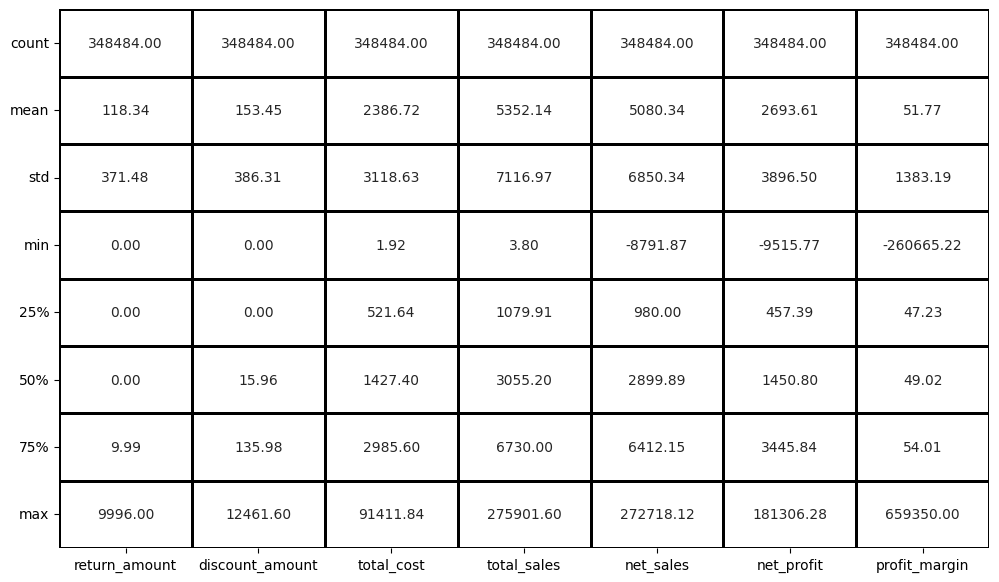

In [12]:
plt.figure(figsize=(12, 7))
sns.heatmap(
    desc,
    annot=True,
    fmt=".2f",
    cmap=sns.color_palette(["white", "white"]),
    cbar=False,
    linecolor="black",
    linewidths=1,
)
plt.yticks(rotation=0)
plt.show()

##### Insights :

- Negative Values :
    1. Net Profit: Minimum values is (-9515.77), indicating losses. Some products or transections may be selling at loss, due to high cost.
    2. Profit Margin: Here minimum value is (-260665.22%), which indicates that there are some cases where revenue is lower than the cost. It can be due to heavy discount because cost of product is higher.
    3. Net Sales : Here minimum values is (-8791.87), which indicates that there is heavy discount or returns.

- Outliers Indicated by High Standard Deviations :
    1. Total Cost & Total Sales : The maximum values are (91411.84) and (275901.6) respectively which is significantly higher than the mean (2386.72) and (5352.13), indicating potential premium products.

>### Handling Outliers

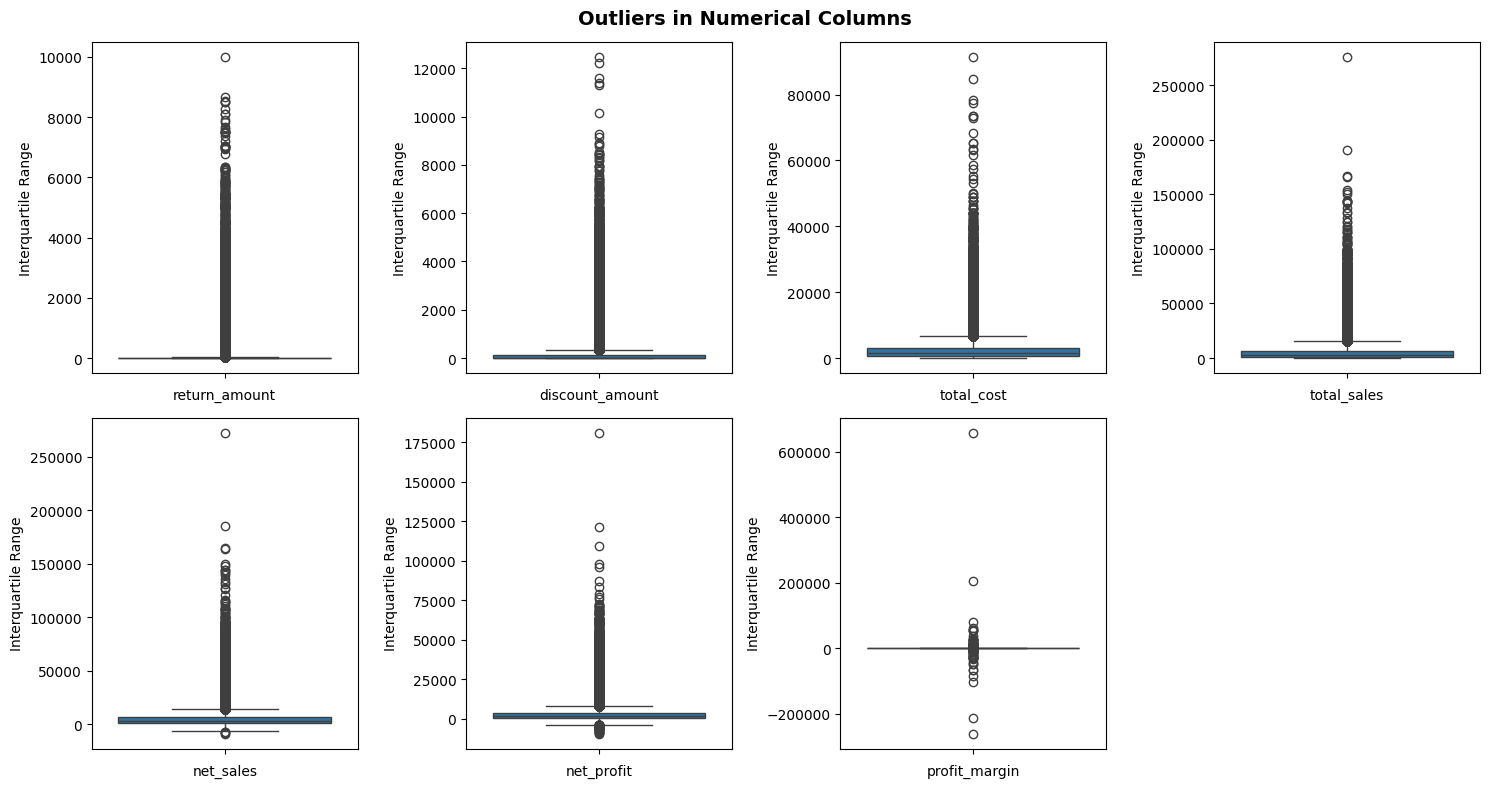

In [13]:
# Box plots to show if outliers are present
numerical_cols = df.select_dtypes(include=["float64"]).columns

plt.figure(figsize=(15, 8))
plt.suptitle("Outliers in Numerical Columns", fontsize=14, fontweight="bold")
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)  # Adjust Grid layout as needed
    sns.boxplot(y=df[col])
    plt.xlabel(col)
    plt.ylabel("Interquartile Range")
plt.tight_layout()
plt.show()

##### Observations :
- Outliers are present in all numerical columns.
- It can be due to premium products and it price.

In [14]:
# Function to check for outliers using IQR method
def has_outliers(data_column):
    Q1 = data_column.quantile(0.25)
    Q3 = data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = data_column[(data_column < lower_bound) | (data_column > upper_bound)]
    return outliers


outliers_return_amount = has_outliers(df["return_amount"])
outliers_discount_amount = has_outliers(df["discount_amount"])
outliers_total_cost = has_outliers(df["total_cost"])
outliers_total_sales = has_outliers(df["total_sales"])
outliers_net_sales = has_outliers(df["net_sales"])
outliers_net_profit = has_outliers(df["net_profit"])

In [15]:
# Filling missing value
def fill_missing_value(df, column, outliers):
    if not outliers.empty:
        df[column] = df[column].fillna(df[column].median())
    else:
        df[column] = df[column].fillna(df[column].mean())


fill_missing_value(df, "return_amount", outliers_return_amount)
fill_missing_value(df, "discount_amount", outliers_discount_amount)
fill_missing_value(df, "total_cost", outliers_total_cost)
fill_missing_value(df, "total_sales", outliers_total_sales)
fill_missing_value(df, "net_sales", outliers_net_sales)
fill_missing_value(df, "net_profit", outliers_net_profit)

If outliers are present then this function will fill missing value with median, if not then mean.

>### Univariate Analysis

#### Distribution of Returns, Discounts, Cost, Net Sales, Net Profit and Profit Margin.

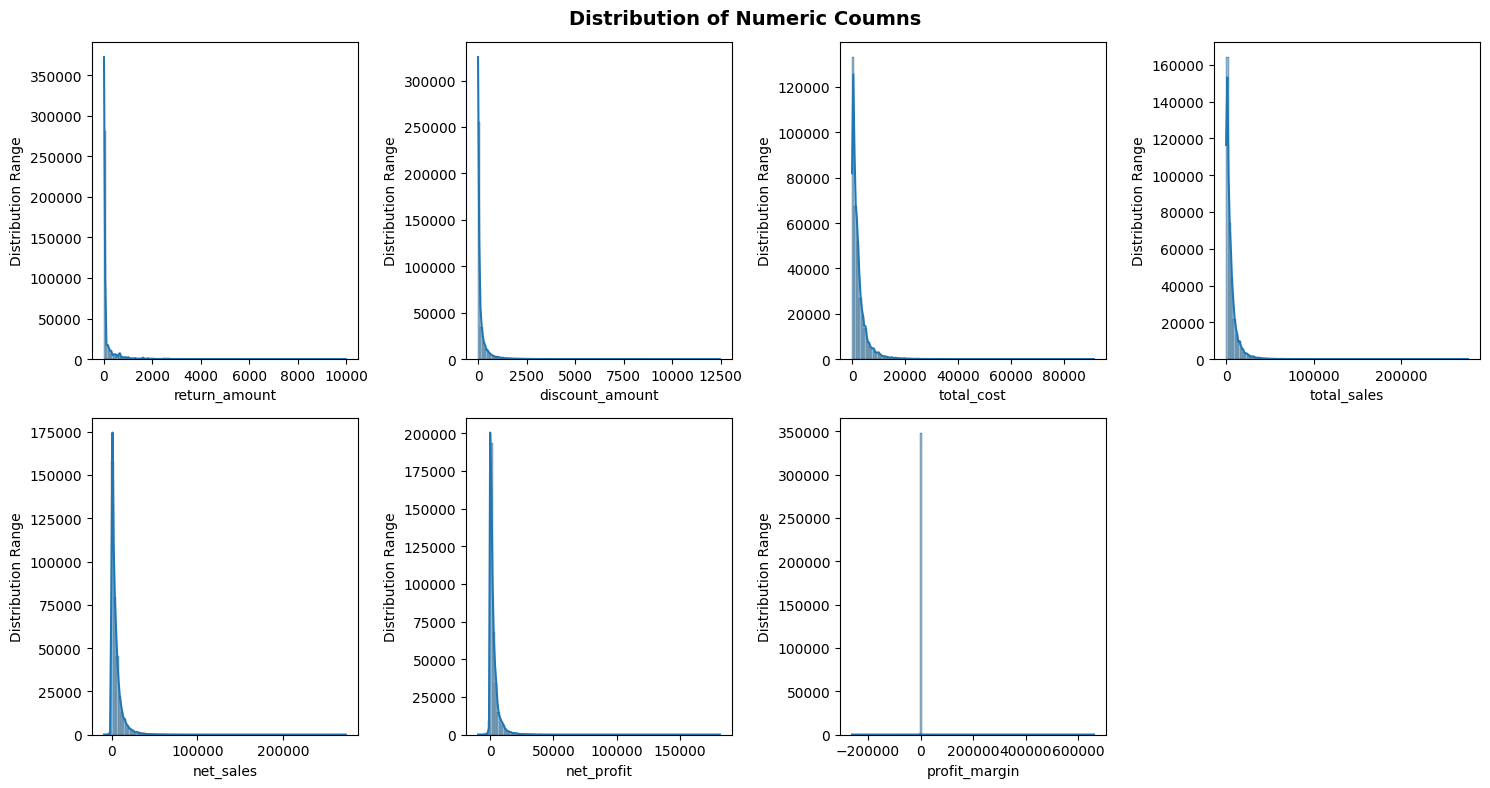

In [ ]:
# Box plots to show if outliers are present
numerical_cols = df.select_dtypes(include=["float64"]).columns

plt.figure(figsize=(15, 8))
plt.suptitle("Distribution of Numeric Coumns", fontsize=14, fontweight="bold")
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)  # Adjust Grid layout as needed
    sns.histplot(data=df, x=col, bins=100, kde=True)
    plt.ylabel("Distribution Range")
plt.tight_layout()
plt.show()

##### Insights:

- **Return Amount:** Predominantly low with occasional high-value returns, highlighting specific products that may require targeted interventions to minimize revenue loss.
- **Discount Amount:** Sparingly applied and typically modest, discounts are managed to preserve profit margins while supporting selective promotional activities.
- **Total Cost:** Mostly moderate with a few substantial outliers, emphasizing the need to control high-cost items for optimizing overall profitability.
- **Total Sales / Net Sales:** Characterized by frequent low-value transactions and infrequent large sales events, reflecting a sales model driven by volume with occasional high-impact sales.
- **Net Profit:** Concentrated on modest gains with rare but significant profit spikes, underscoring the critical impact of high-margin transactions for overall financial performance.
- **Profit Margin:** Exhibits high variability with many low or negative margins offset by a few exceptionally profitable transactions, indicating areas for focused margin enhancement and risk management.


#### Most frequent Product Categories and Brands.

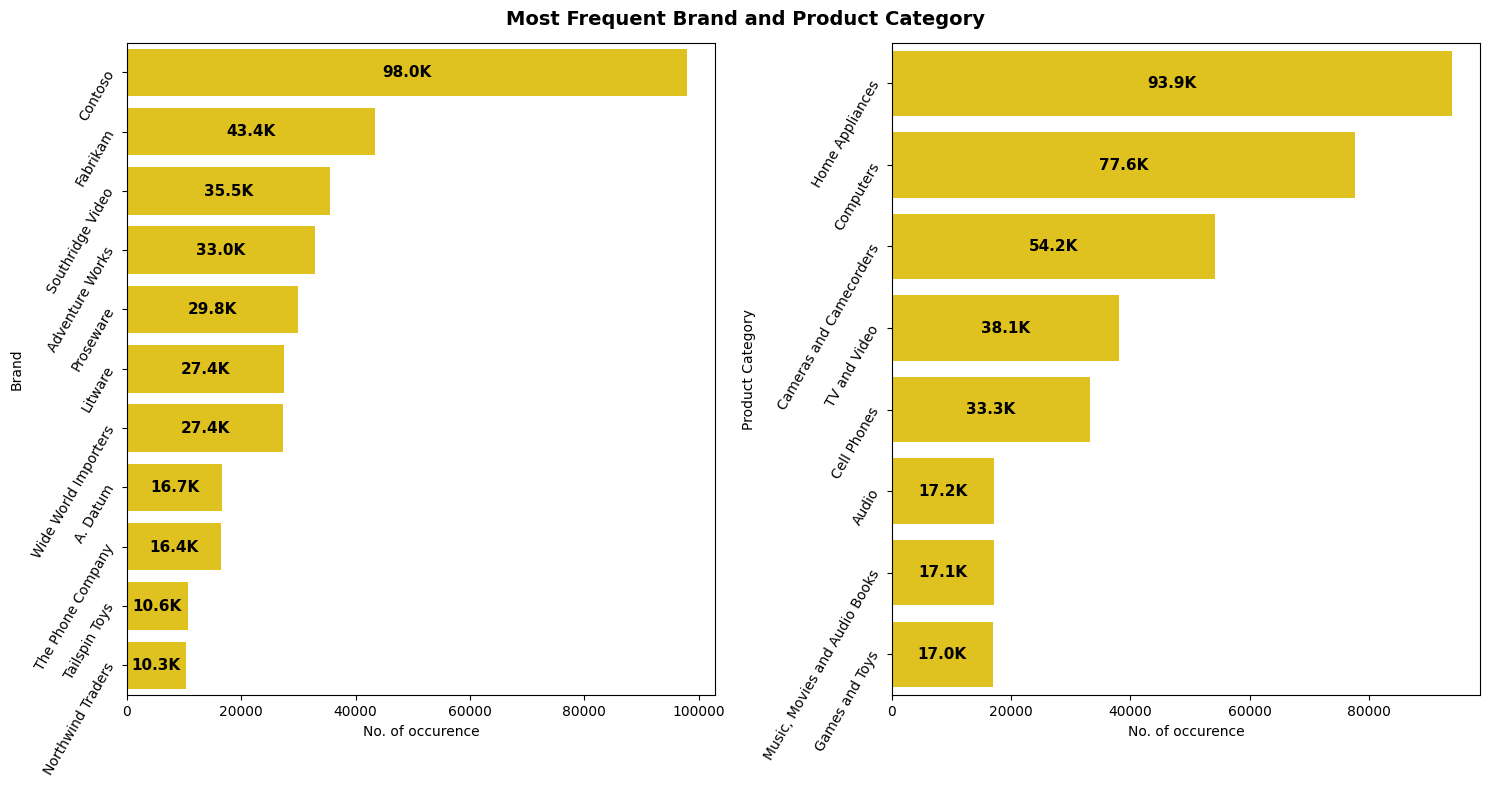

In [17]:
# Using countplot to show no of occurence
category_cols = {"brand": "Brand", "product_category": "Product Category"}

plt.figure(figsize=(15, 8))
plt.suptitle("Most Frequent Brand and Product Category", fontsize=14, fontweight="bold")
for i, col in enumerate(category_cols):
    plt.subplot(1, 2, i + 1)  # Adjust Grid layout as needed
    cc = sns.countplot(data=df, y=col, color="gold", order=df[col].value_counts().index)
    plt.xlabel("No. of occurence")
    plt.ylabel(category_cols[col])
    plt.yticks(rotation=60)
    for bar in cc.containers:
        values = [rect.get_width() for rect in bar]
        formatted_labels = [
            f"{value / 1000:.1f}K" if value >= 1000 else f"{value:.1f}"
            for value in values
        ]
        cc.bar_label(
            bar,
            labels=formatted_labels,
            label_type="center",
            fontweight="bold",
            fontsize=11,
        )
plt.tight_layout()
plt.show()

##### Insights :

- Brand (Left Plot):
    1. Contoso is the leading brand with 98K transactions, far ahead of others.
    2. Secondary brands like Fabrikam (43.4K) and Southridge Video (35.5K) also have a strong presence.
    3. Brands such as Northwind Traders (10.3K) and Tailspin Toys (10.6K) show very limited transactions.

- Product Category (Right Plot):
    1. Home Appliances (93.9K) and Computers (77.6K) are the most frequently sold categories.
    2. Cameras & Camcorders (54.2K) and TV & Video (38.1K) form the mid-tier categories.
    3. Audio (17.2K), Music, Movies & Audiobooks (17.1K), and Games & Toys (17K) have the least frequency.

>### Bivariate/Multivariate Analysis

#### Correlation Between Numerical Columns

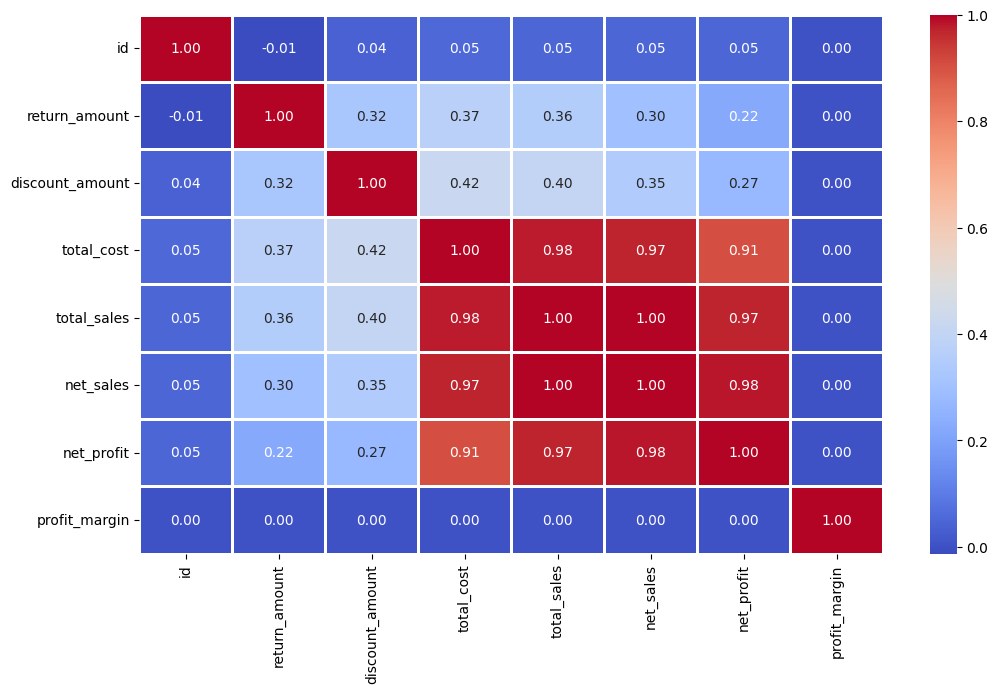

In [18]:
# correlation heatmap to find out relation between columns

plt.figure(figsize=(12, 7))
sns.heatmap(
    data=df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1,
)
plt.show()

##### Correlation Insights :

+ Net Sales has weak correlation with Return Amount (0.30) and Discount Amount (0.35), which indicates that there is no significant impact of discounts and returns on sale. May be impact is seasonal, during holidays.
+ There is very strong correlation between Total Cost and Total Sales (0.98), Indicating that profit margin will stay about the same.
+ There is very strong positive correlation between Net Sales and Net Profit which means if sales is increasing, net profit also tends to increase proportionally. Indicating company effectively converting sales into profit.

#### Q1: Which brands contribute most to net sales and net profit?

In [19]:
# Group by brand, aggregating net sales and net profit by sum

group_brand = (
    df.groupby(by=["brand"], as_index=False)
    .agg(
        net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by=["net_sales"], ascending=[False])
)
group_brand

,brand,net_sales,net_profit
3,Fabrikam,3.848159e+08,2.110488e+08
2,Contoso,3.531667e+08,1.835066e+08
1,Adventure Works,2.238081e+08,1.211596e+08
10,Wide World Importers,1.682343e+08,9.096728e+07
6,Proseware,1.499641e+08,7.884118e+07
9,The Phone Company,1.057288e+08,5.503097e+07
4,Litware,9.674056e+07,4.675621e+07
0,A. Datum,9.578611e+07,5.211037e+07
5,Northwind Traders,8.929310e+07,4.684115e+07
7,Southridge Video,8.441259e+07,4.313404e+07


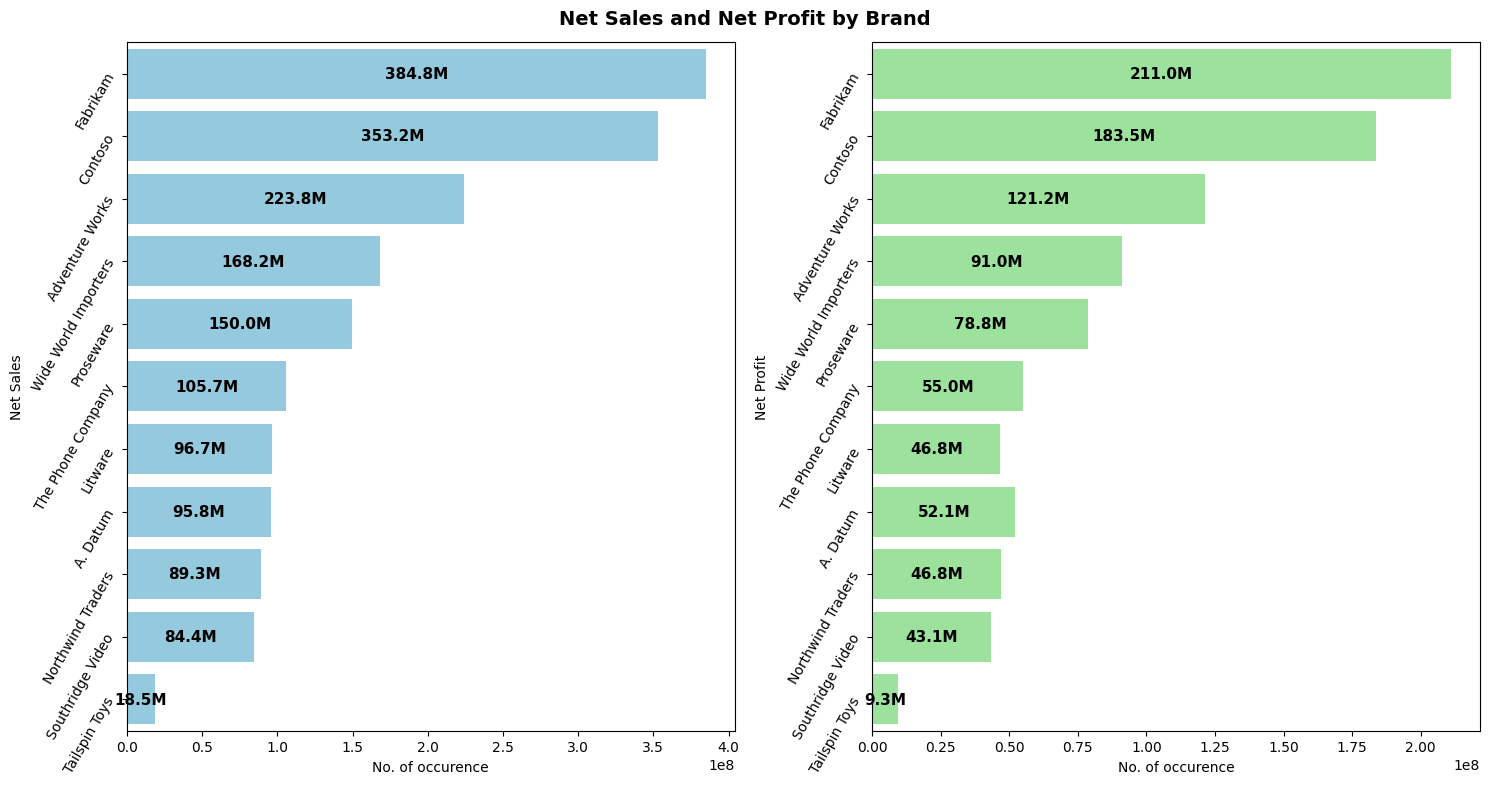

In [20]:
# Bar Chart to show net sales and net profit by brand
sales_profit = {"net_sales": "Net Sales", "net_profit": "Net Profit"}
colors = ["skyblue", "lightgreen"]

plt.figure(figsize=(15, 8))
plt.suptitle("Net Sales and Net Profit by Brand", fontsize=14, fontweight="bold")
for i, col in enumerate(sales_profit):
    plt.subplot(1, 2, i + 1)  # Adjust Grid layout as needed
    cc = sns.barplot(data=group_brand, x=col, y="brand", color=colors[i])
    plt.xlabel("No. of occurence")
    plt.ylabel(sales_profit[col])
    plt.yticks(rotation=60)
    for bar in cc.containers:
        values = [rect.get_width() for rect in bar]
        formatted_labels = [
            f"{value / 1000000:.1f}M" if value >= 1000000 else f"{value:.1f}"
            for value in values
        ]
        cc.bar_label(
            bar,
            labels=formatted_labels,
            label_type="center",
            fontweight="bold",
            fontsize=11,
        )
plt.tight_layout()
plt.show()

#### Insights :

- Net Sales by Brand (Left Plot):
    1. Identifies the brand Fabrikam (384.8M) as the primary driver of Sales, followed by Contoso (353.2M).
    2. Fabrikam is more prominent among customers, It can be due to better quality, reputation or marketing.
    3. Fabrikam have better pricing strategy, product innovation, distribution or brand loyality.

- Net Profit by Brand (Right Plot):
    1. Fabrikam is the most profitable brand with net profit around 211M million, leading the pack by a significant margin, followed by Contoso with 183.5M net profit.
    2. The lowest profit contributors such as Southridge Video and Tailspin Toys are below 10 million net profit, suggesting limited profitability or potential areas for strategic review.

#### Q2: Which sales channels are the most and least profitable?

In [21]:
# Group by channel, aggregating net profit by sum

group_channel = (
    df.groupby(by="channel", as_index=False)
    .agg(
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by="net_profit", ascending=False)
)

group_channel.head()

,channel,net_profit
3,Store,4.741180e+08
1,Online,2.189795e+08
2,Reseller,1.574502e+08
0,Catalog,8.813380e+07


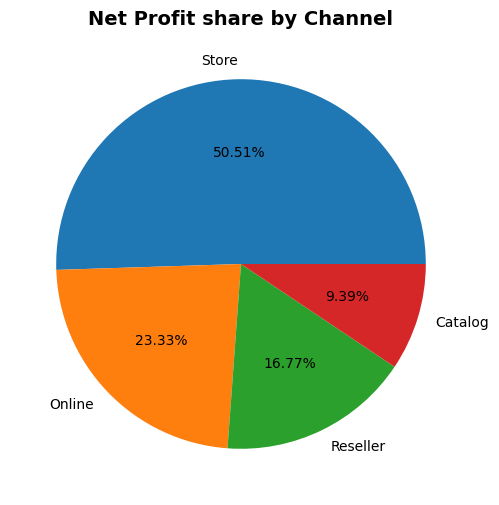

In [22]:
# Visualizaion of profit proportion for each channel
plt.figure(figsize=(6, 6))

plt.pie(data=group_channel, x="net_profit", labels="channel", autopct="%1.2f%%")
plt.title("Net Profit share by Channel", fontsize=14, fontweight="bold")
plt.show()

##### Insights :

- Store channel is generating most of the profit which is above 50% of Net Profit.
- Lowest profit is generated through catalog channel (9.39%).
- Likely due to higher sales volume despite having the smallest profit margin.

#### Q3: What is the percentage contribution of discount amount, return amount, net sales, and net profit by each product category to the total figures?

In [23]:
# Group by Product Category, aggregating discount amount, return amount, total cost, net sales and net profit by sum

group_product = (
    df.groupby(by="product_category", as_index=False)
    .agg(
        discount_amount=pd.NamedAgg(column="discount_amount", aggfunc="sum"),
        return_amount=pd.NamedAgg(column="return_amount", aggfunc="sum"),
        net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by="net_profit", ascending=False)
)

group_product.set_index(
    keys="product_category", inplace=True
)  # Now Product Category is Index

for col in group_product.columns:
    group_product[col] = ((group_product[col] / group_product[col].sum()) * 100).round(
        1
    )

group_product

,discount_amount,return_amount,net_sales,net_profit
product_category,,,,
Home Appliances,36.4,36.6,29.5,28.7
Cameras and Camecorders,20.9,20.7,22.7,24.3
Computers,24.1,24.1,22.3,21.9
TV and Video,10.0,10.0,13.3,12.9
Cell Phones,5.2,5.2,7.8,7.6
Audio,1.1,1.2,1.7,1.7
"Music, Movies and Audio Books",1.4,1.4,1.4,1.6
Games and Toys,0.9,0.9,1.4,1.3


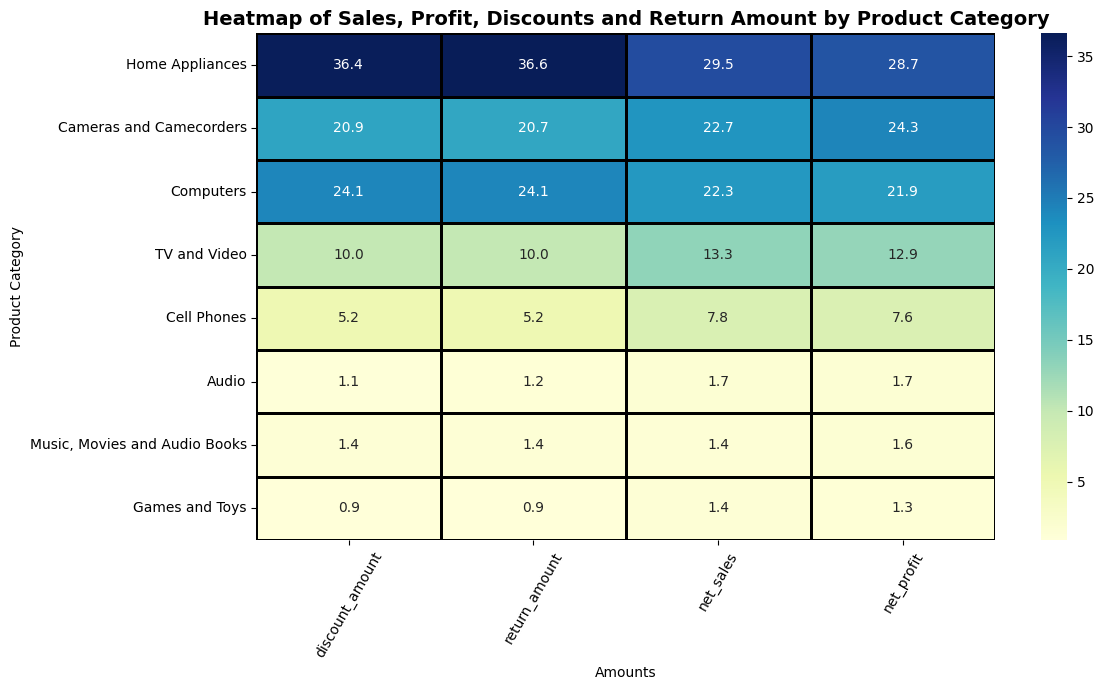

In [25]:
# Visualization of proportion of discount amount, return amount, net sales and net profit by Product Category
plt.figure(figsize=(12, 7))

sns.heatmap(
    data=group_product,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=1,
    linecolor="black",
)
plt.title(
    "Heatmap of Sales, Profit, Discounts and Return Amount by Product Category",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Amounts")
plt.xticks(rotation=60)
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

##### Insights :

- Discount Amount :
    1. Home Appliances has highest discount among all product category (36.41%), followed by Computers (24.07%).
    2. Discount is very high in Home Appliances category due to high sales price per unit.

- Return Amount :
    1. Home Appliances has highest returns among all product category (36.56%), followed by Computers (24.15%).
    2. It may be due to product quality issue like defects, malfunctioned or unmat customer expectations.
    3. Some categories are more susceptible to return fraud or policy abuse.

- Net Sales :
    1. Home Appliances has highest sales among all product category (29.49%), followed by Cameras and Camecorders (22.73%).
    2. This is due to popularity among customers.
    3. May warrant focused marketing efforts or investment.

- Net Profit :
    1. Home Appliances product category is generating the highest profit (28.72%), followed by Cameras and Camecorders (24.35%).
    2. Likely due to higher sales volume because when compare to profit margin there is no significant difference.

#### Q4: How discount amount and return amount impact profitablity?

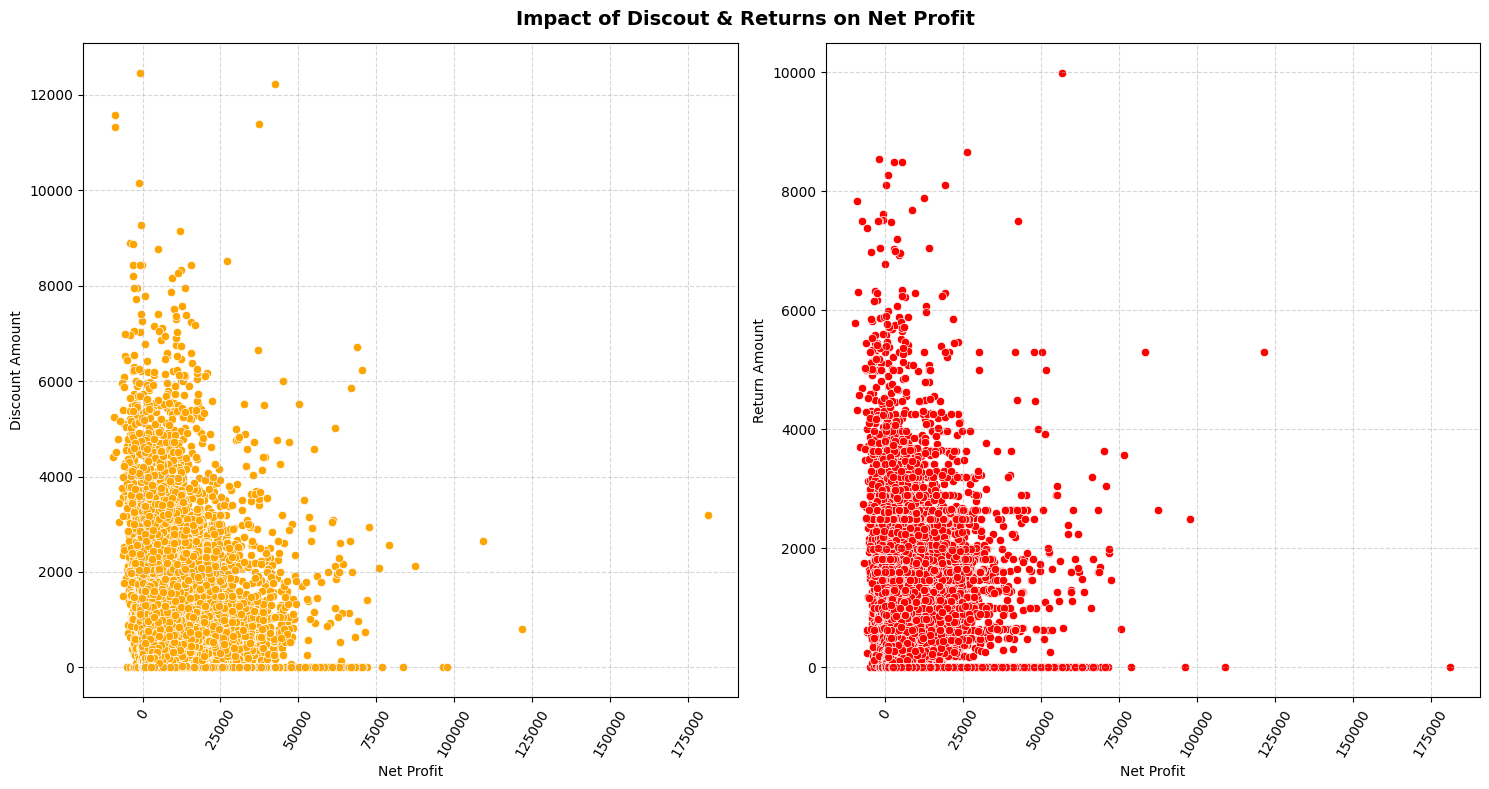

In [26]:
# Scatter plot to show impact of return amount and discount amount on Net Profit
plt.figure(figsize=(15, 8))
plt.suptitle(
    "Impact of Discout & Returns on Net Profit", fontsize=14, fontweight="bold"
)
discount_return = {
    "discount_amount": "Discount Amount",
    "return_amount": "Return Amount",
}
colors = ["orange", "red"]
for i, col in enumerate(discount_return):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data=df, x="net_profit", y=col, color=colors[i])
    plt.xlabel("Net Profit")
    plt.xticks(rotation=60)
    plt.ylabel(discount_return[col])
    plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

##### Insights :

- Net Profit vs. Discount Amount (Left Plot):
    1. Higher discount amounts generally correlate with lower or negative net profits, indicating discounts can erode profitability.
    2. Most transactions cluster around low discount amounts and moderate net profits, suggesting careful discount use supports profitability.
    3. Large net profits rarely coincide with high discount amounts, implying that top profits come from low or no discount sales.

- Net Profit vs. Return Amount (Right Plot):
    1. Increasing return amounts are associated with reduced net profits, showing returns negatively impact profitability.
    2. Most data points show low returns and low to moderate net profit, highlighting that returns are typically small but impactful.
    3. High net profits are uncommon alongside large returns, underlining the detrimental effect of returns on overall profit.



#### Q5: How do regional variations influence sales and profit margin performance, and what factors contribute to these differences across geographic markets?

In [27]:
group_country = (
    df.groupby(by="country", as_index=False)
    .aggregate(
        net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
        net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
    )
    .sort_values(by="net_sales", ascending=False)
).head(10)

group_country["profit_margin"] = (
    (group_country["net_profit"] / group_country["net_sales"]) * 100
).round(1)

group_country

,country,net_sales,net_profit,profit_margin
32,United States,7.587516e+08,3.865265e+08,50.9
4,China,2.800195e+08,1.504576e+08,53.7
7,Germany,1.671528e+08,8.938783e+07,53.5
6,France,1.178357e+08,6.369246e+07,54.1
31,United Kingdom,5.496434e+07,2.966755e+07,54.0
3,Canada,4.915316e+07,2.723524e+07,55.4
13,Japan,4.747962e+07,2.610266e+07,55.0
1,Australia,2.595126e+07,1.452452e+07,56.0
9,India,2.579490e+07,1.436627e+07,55.7
20,Russia,2.306528e+07,1.293855e+07,56.1


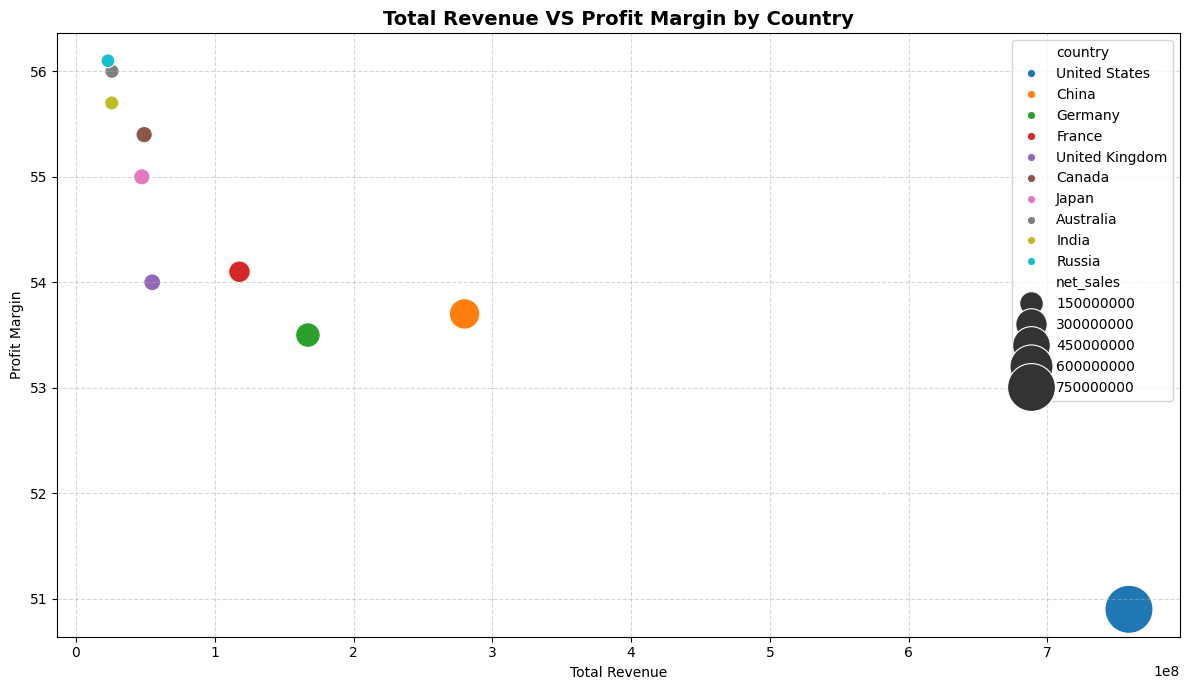

In [28]:
# Top 10 Sales VS Profit Margin by Country

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=group_country.head(10),
    x="net_sales",
    y="profit_margin",
    hue="country",
    size="net_sales",
    sizes=(100, 1200),
)
plt.title("Total Revenue VS Profit Margin by Country", fontsize=14, fontweight="bold")
plt.xlabel("Total Revenue")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

##### Insights :
- **High Sales ≠ High Profitablity :** United States has highest net sales, but lowest profit margin. This could be due to intense competition, higher cost and aggressive discounting.
- **Cost Structures & Business Matter :** High operational costs, supply chain challanges, pricing strategies, or local regulation can reduce the profit margins even where sales are strong.
- **Consistent Business Model :** This small range of profit margin indicate that the company has fairly consistent pricing and cost model accross these countries.

>### Time-Series Analysis

#### Q6: To what extent do discounts and returns influence overall net sales, and what strategic actions can be taken to optimize their impact on the organization’s bottom line?

In [29]:
# Creating column qtr_year for line plot

df["qtr_year"] = df["date_key"].dt.to_period("Q").astype(str)

In [30]:
# Group by qtr and year, aggregating net profit, discount and returns by sum

group_qtr = df.groupby(by="qtr_year", as_index=False).aggregate(
    {"net_sales": "sum", "discount_amount": "sum", "return_amount": "sum"}
)

group_qtr

,qtr_year,net_sales,discount_amount,return_amount
0,2007Q1,1.326958e+08,4934035.19,3584139.93
1,2007Q2,1.611322e+08,1296062.79,4534544.81
2,2007Q3,1.524859e+08,4674580.22,3885370.15
3,2007Q4,1.602943e+08,9582277.72,4353079.47
4,2008Q1,1.246122e+08,4171477.46,2887615.16
5,2008Q2,1.504122e+08,1672248.68,3244893.93
6,2008Q3,1.550287e+08,3675958.65,3327673.94
7,2008Q4,1.524724e+08,7421441.39,3295612.27
8,2009Q1,1.279223e+08,4358559.53,2765378.08
9,2009Q2,1.497693e+08,1703949.10,3159871.34


In [31]:
# Consolidating all numerical columns into one column for line plot

group_qtr_melt = pd.melt(
    frame=group_qtr,
    id_vars="qtr_year",
    value_vars=["net_sales", "discount_amount", "return_amount"],
    var_name="metric",
    value_name="amount",
)
group_qtr_melt.head()

,qtr_year,metric,amount
0,2007Q1,net_sales,1.326958e+08
1,2007Q2,net_sales,1.611322e+08
2,2007Q3,net_sales,1.524859e+08
3,2007Q4,net_sales,1.602943e+08
4,2008Q1,net_sales,1.246122e+08


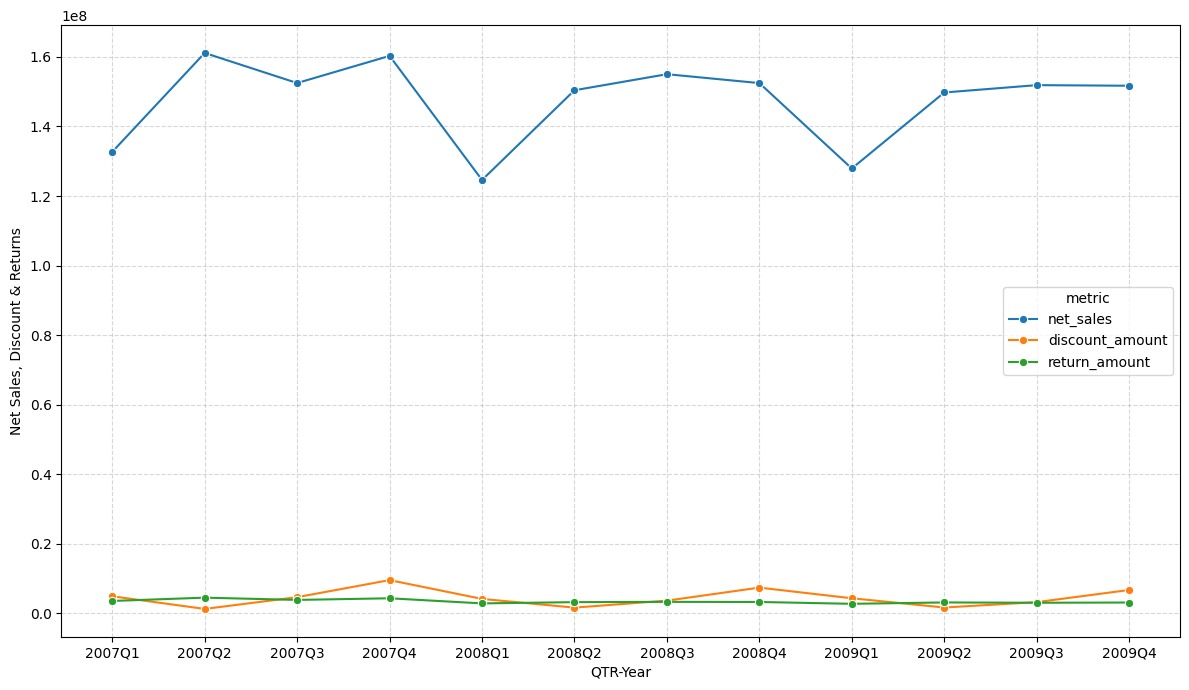

In [32]:
# Line Plot for trend visulaization

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=group_qtr_melt,
    x="qtr_year",
    y="amount",
    hue="metric",
    marker="o",
)
plt.xlabel("QTR-Year")
plt.ylabel("Net Sales, Discount & Returns")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

##### Insights :

- Significant increases in discount amounts directly improve net sales, highlighting the importance of disciplined pricing for maintaining healthy financial performance.
- Periods with stable or lower discounts and consistently show stronger net sales, suggesting that keeping these figures under control is one of the most effective ways to protect business profitability.
- These patterns suggest that managing discount timing and preparing for post-holiday slowdowns are important levers to optimize profitability across quarters.
- Return has very low impact on sales over time.

#### Q7: Is profit margin improving or declining over time?

In [33]:
group_qy = df.groupby(by="qtr_year", as_index=False).agg(
    net_sales=pd.NamedAgg(column="net_sales", aggfunc="sum"),
    net_profit=pd.NamedAgg(column="net_profit", aggfunc="sum"),
)

group_qy["profit_margin"] = (
    (group_qy["net_profit"] / group_qy["net_sales"]) * 100
).round(2)  # New Profit Margin Column

group_qy.head()

,qtr_year,net_sales,net_profit,profit_margin
0,2007Q1,1.326958e+08,70885150.13,53.42
1,2007Q2,1.611322e+08,86081104.74,53.42
2,2007Q3,1.524859e+08,80430887.62,52.75
3,2007Q4,1.602943e+08,82261713.67,51.32
4,2008Q1,1.246122e+08,65839397.50,52.84


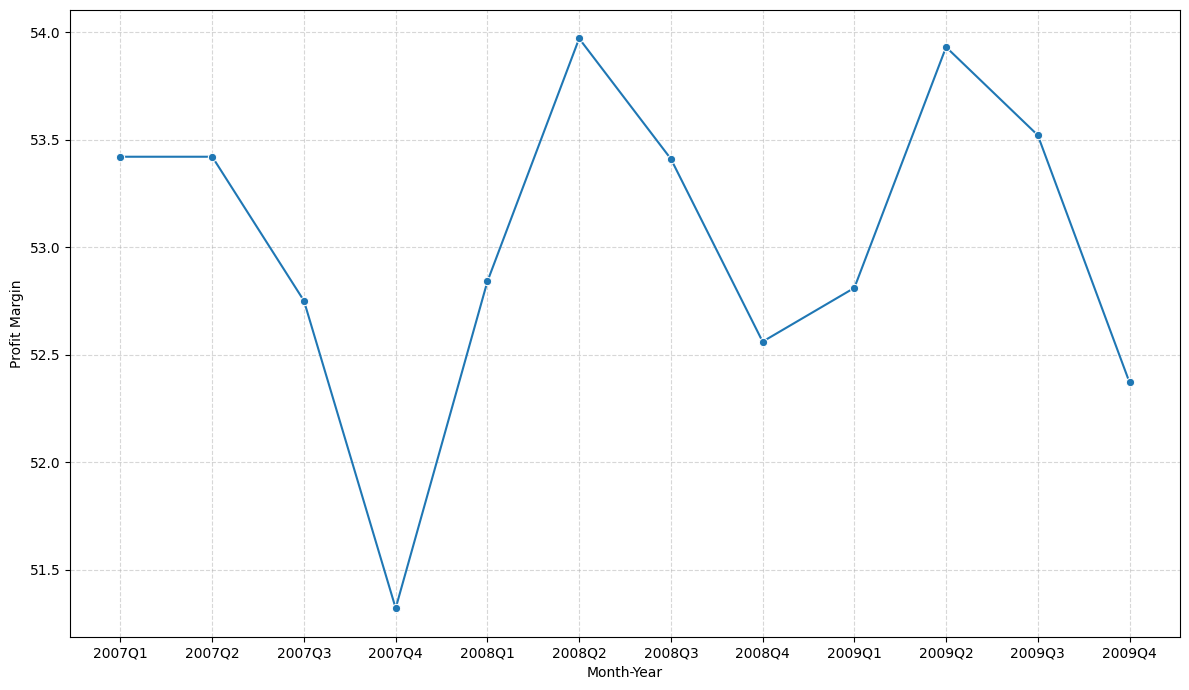

In [34]:
# Visulization of Profit Margin over time
plt.figure(figsize=(12, 7))
sns.lineplot(data=group_qy, x="qtr_year", y="profit_margin", marker="o")
plt.xlabel("Month-Year")
plt.ylabel("Profit Margin")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Insights :

- Retailers feel pressure to offer promotions to win customers from competitiors, sacrificing margins to retain or grow market share.
- Shoppers expect deals and are less loyal to brands, switching easily to find the best price.
- Holidays are often used to clear out inventory, sometimes at the cost of profitablity.

>### Hypothesis Testing

#### Q8 : How do profit margins vary among different countries, and what factors might explain these differences?

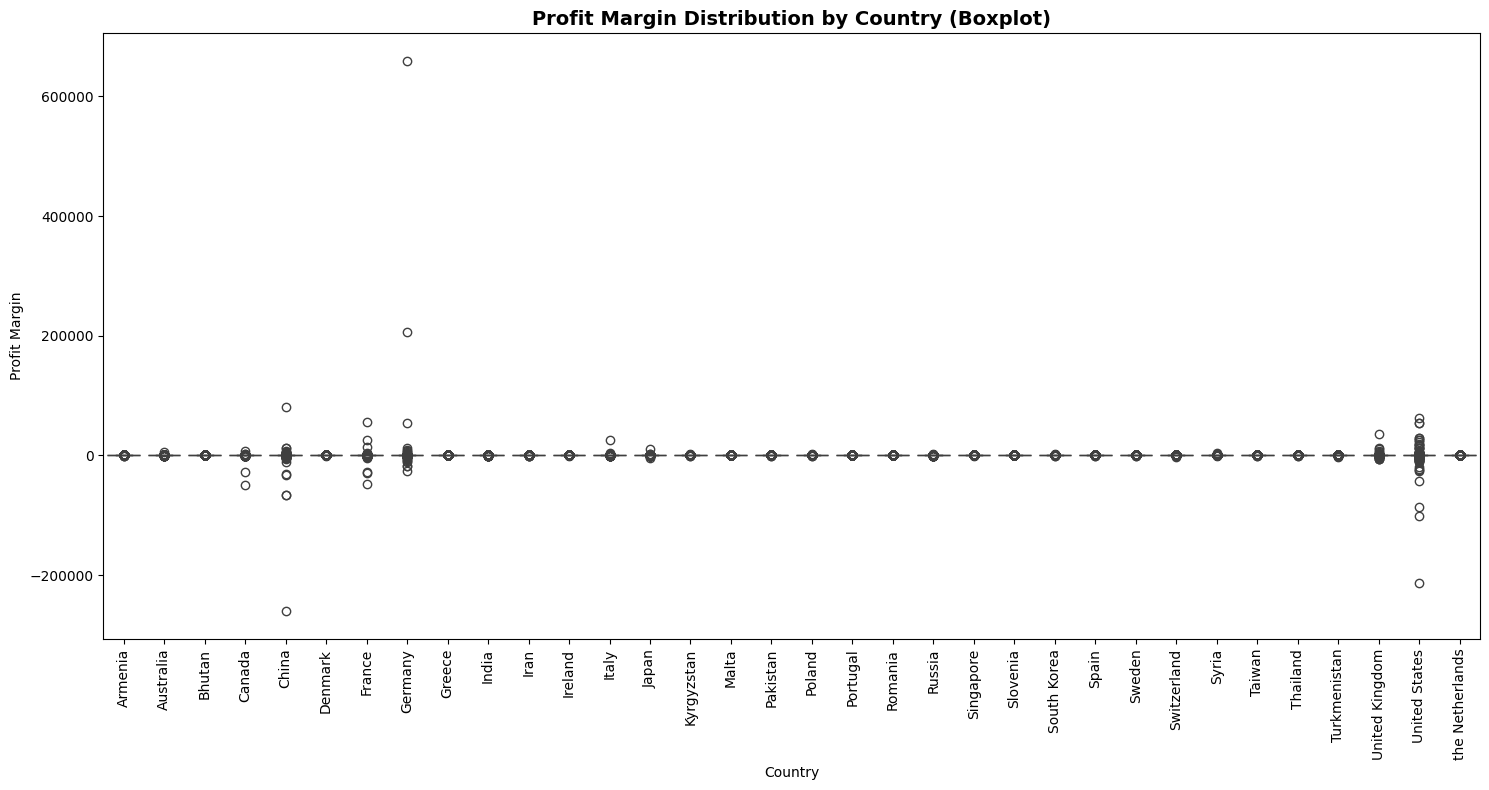

In [35]:
# Visualizing through Box Plot, profit margins by countries

plt.figure(figsize=(15, 8))
sns.boxplot(
    x="country",
    y="profit_margin",
    data=df,
    order=df["country"].sort_values(),
)

plt.title("Profit Margin Distribution by Country (Boxplot)", fontsize=14, weight="bold")
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Profit Margin")
plt.tight_layout()
plt.show()

#### Insights :

- Most Profit Margins are near 0 :
    1. For almost all countries, the boxes (IQR) and medians are clustered around 0.
    2. This means the majority of sales have very small profit margins, possibly close to break-even.

- Presence of extreme outliers :
    1. Countries like China, Germany and United States show very high outliers (up to 600000+).
    2. Negative outliers are also present (below -200000), meaning in some cases losses were very large.

#### **Perfoming Hypothesis Testing (ANOVA)**

In [36]:
# Group by on countries
group_country = df.groupby(by="country", observed=False)
# Insert all profit margins into a list for each country
margin_country_wise = group_country["profit_margin"].apply(list)
margin_country_wise

country
Armenia            [47.71, 62.71, 66.08, -9.25, 47.71, 66.08, 66....
Australia          [40.57, 48.42, 46.55, 13.83, 65.68, 65.27, 43....
Bhutan             [65.26, 52.37, 52.93, 52.93, 53.85, 47.71, 43....
Canada             [36.69, 47.06, 48.37, 47.06, 49.02, 66.31, 42....
China              [44.76, 49.02, 43.09, 49.0, -35.52, 49.03, 44....
Denmark            [66.02, 45.78, 40.04, 43.35, 49.02, 43.35, 46....
France             [39.96, 39.58, 63.19, 31.6, 40.04, 37.51, 61.5...
Germany            [48.91, 61.02, 47.71, 66.87, 49.86, 43.0, 46.3...
Greece             [54.02, 32.7, 63.21, 40.02, 43.35, 7.3, 49.01,...
India              [48.83, 62.71, 49.01, 46.55, 46.33, 66.87, 32....
Iran               [54.01, 47.72, 53.95, 50.18, 47.56, 53.01, 34....
Ireland            [46.35, 40.02, 66.53, 42.52, 36.28, 46.33, 47....
Italy              [66.87, 64.18, 40.66, 48.9, 43.36, 41.46, 27.1...
Japan              [47.81, 52.94, 48.42, 47.81, 51.79, 49.02, 65....
Kyrgyzstan         [63.19,

In [37]:
from scipy import stats

# Performing one-way ANOVA test
f_stats, p_value = stats.f_oneway(*margin_country_wise)

print("ANOVA Hypothesis")
print("Confidence Level is 95%")
print("H0 : The mean of Profit Margin is same for all the countries")
print("H1 : Atleast one country's mean of Pofit Margin is different")
print(f"F-Statstics : {f_stats:.4f}")
print(f"P Value : {p_value:.6f}")

# compare P Value with significance level
alpha = 0.05  # standered choice

if p_value < alpha:
    print(
        "Reject null hypothesis:\n- Significant difference in Profit Margin between countries"
    )
else:
    print(
        "Fail to reject null hypothesis:\n- No significant difference in Profit Margin between countries"
    )

ANOVA Hypothesis
Confidence Level is 95%
H0 : The mean of Profit Margin is same for all the countries
H1 : Atleast one country's mean of Pofit Margin is different
F-Statstics : 0.3691
P Value : 0.999646
Fail to reject null hypothesis:
- No significant difference in Profit Margin between countries


>## **Key Insights**

##### Insights:

- The catalog channel currently underperforms in profit generation relative to other channels.
- Home Appliances has highest sales (29.5%) but high returns (36.6%).
- United States has highest sales but lowest profit margin (50.9%).
- During holiday session where profit margin decline repidely.

>## **Recommendations**

##### Based on the analysis, the company should: 

- Investigate cost structures, pricing strategies or customer engagement to improve margins in Catalog channel.
- Conduct a detailed quality and customer satisfaction analysis to identify root causes for the high return rates in the home appliances category.
- For the United States, conduct a comprehensive analysis of pricing, discounting strategies, operational expenses, and return rates, and focus on optimizing these factors to enhance overall profit margin.
- Monitor discount strategies closely during holiday periods to control profit erosion.
- Optimize inventory for seasonal demand.